In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [3]:
%reload_ext autoreload
%autoreload 2
import ACPF

2025-11-18 15:02:17.629251: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 15:02:24.553776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 15:02:33.443157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Utilisation de Processus Gaussien pour prédire une sortie scalaire à partir de données d'entrées fonctionnelles v2

On importe notre plan d'expérience créé au préalable dans le notebook **Doe Functionnal**

In [4]:
T=36                  # On regarde toutes les 10 minutes pendant 6 heures, ca nous fait donc 36 points
t=np.linspace(0,6,T)
dt = t[1] - t[0] 

best_plan_values = np.load("./data/best_plan_values.npy")

test_values = np.load("./data/test_values.npy")
print(best_plan_values.shape)
print(test_values.shape)

(200, 8, 36)
(2000, 8, 36)


In [5]:
def Campbell(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

On discrétise le domaine spatial.

In [6]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On calcul à chaque pixel la hauteur d'eau moyenne, max et min pour une entrée: 

In [7]:
def HE_moyenne(e, z1, z2):
    s = 0
    for i in range(e.shape[1]):
        s+=Campbell(e[:, i], z1, z2) * dt
    return s/e.shape[1]

def HE_max(e, Z1, Z2):
    M = np.zeros_like(Z1)
    for i in range(Z1.shape[0]):       
        for j in range(Z1.shape[1]):  
            vals = [Campbell(e[:, k], Z1[i,j], Z2[i,j])*dt for k in range(e.shape[1])]
            M[i,j] = np.max(vals)
    return M

def HE_min(e, Z1, Z2):
    M = np.zeros_like(Z1)

    for i in range(Z1.shape[0]): 
        for j in range(Z1.shape[1]):
            vals = [Campbell(e[:, k], Z1[i,j], Z2[i,j])*dt for k in range(e.shape[1])]
            M[i,j] = np.min(vals)
    return M


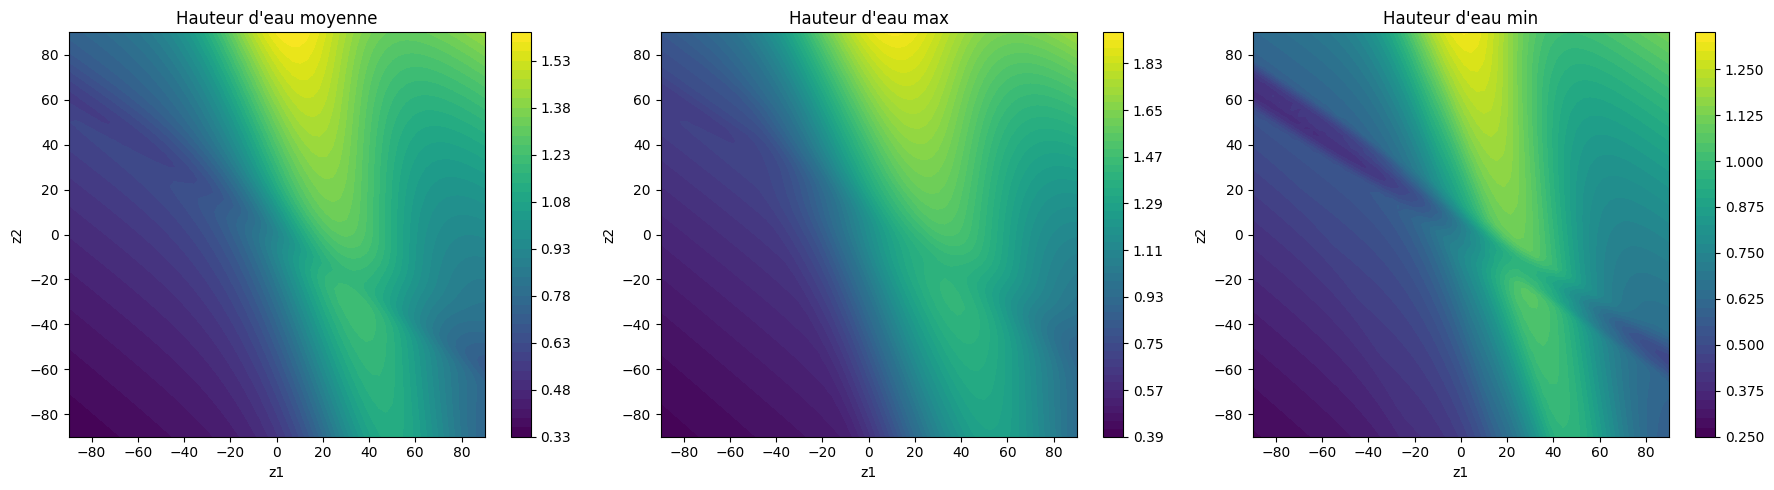

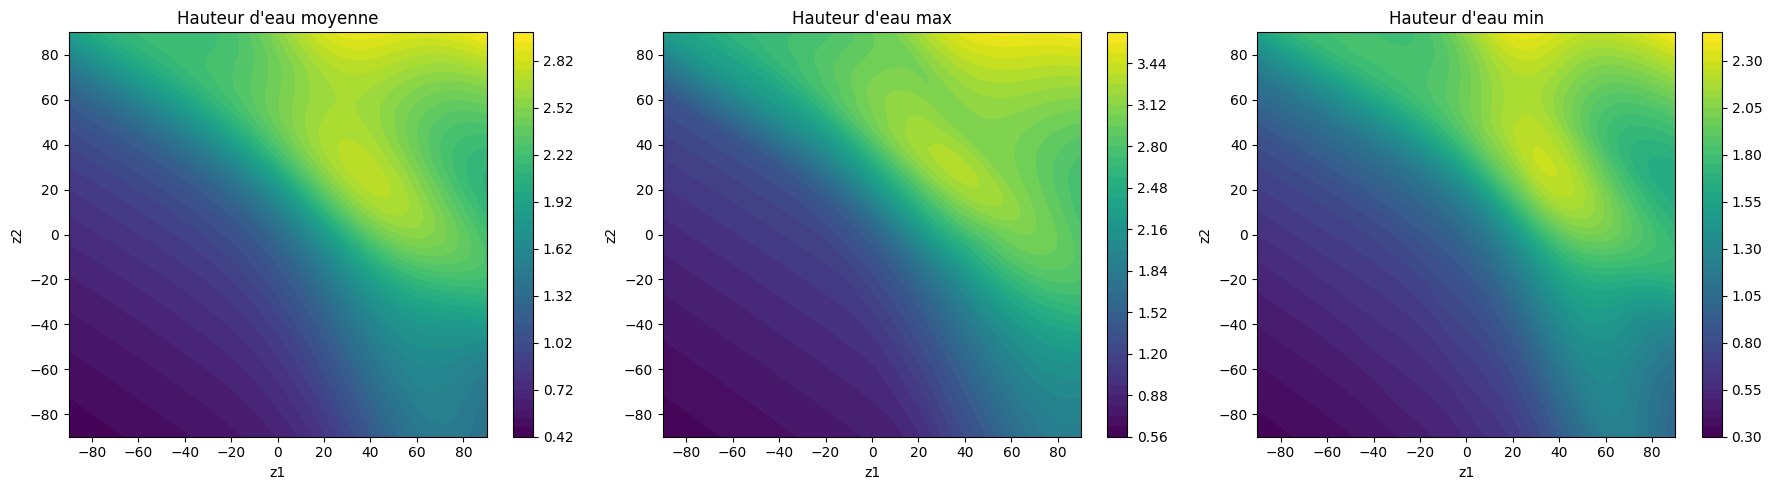

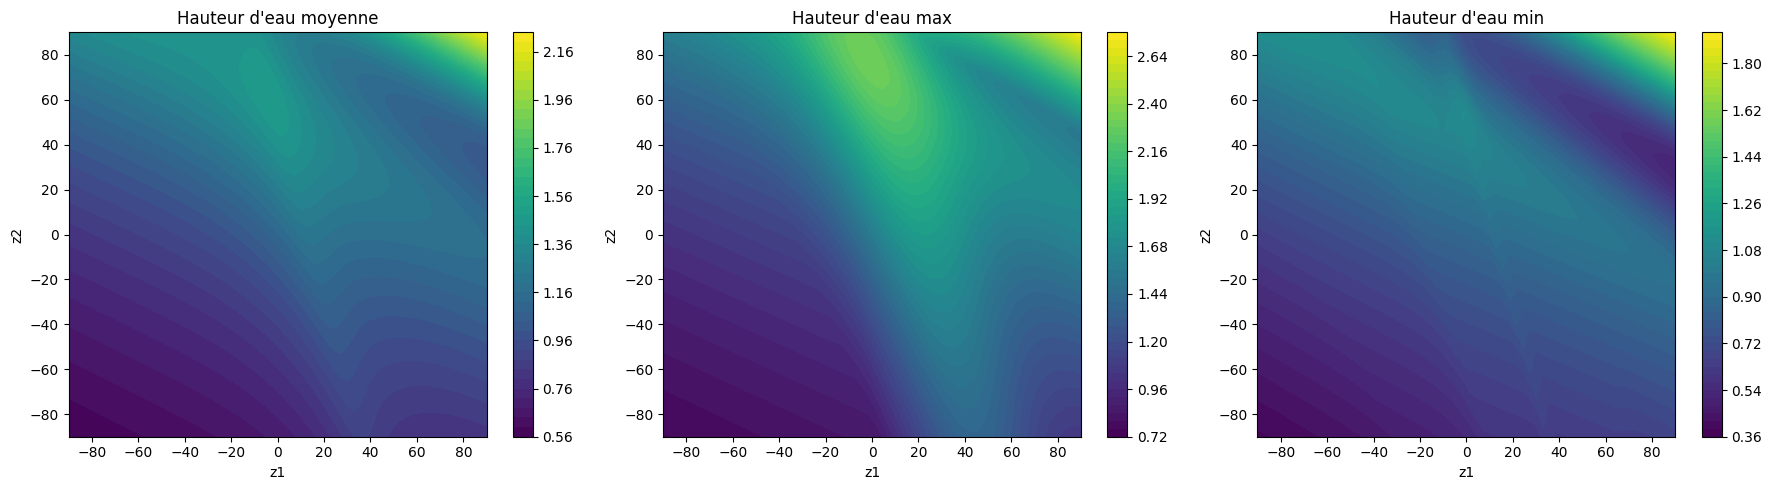

In [8]:
for i in range(3):
    e=best_plan_values[i]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # moyenne
    im0 = axes[0].contourf(Z1, Z2, HE_moyenne(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im0, ax=axes[0])
    axes[0].set_title("Hauteur d'eau moyenne")
    axes[0].set_xlabel("z1")
    axes[0].set_ylabel("z2")

    # max
    im1 = axes[1].contourf(Z1, Z2, HE_max(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im1, ax=axes[1])
    axes[1].set_title("Hauteur d'eau max")
    axes[1].set_xlabel("z1")
    axes[1].set_ylabel("z2")

    # min
    im2 = axes[2].contourf(Z1, Z2, HE_min(e, Z1, Z2), levels=50, cmap='viridis')
    fig.colorbar(im2, ax=axes[2])
    axes[2].set_title("Hauteur d'eau min")
    axes[2].set_xlabel("z1")
    axes[2].set_ylabel("z2")

    plt.tight_layout()
    plt.show()

In [9]:
n_features = 8   # x1..x8
n_test = 2000
n_train = 200

x_test = test_values  # shape = (2000,8,36)
y_test = np.zeros((n_test,n_grid*n_grid))   # shape = (2000, 4096)

x_train = best_plan_values # shape = (200,8,36)
y_train = np.zeros((n_train,n_grid*n_grid))   # shape = (200, 4096)

#On calcul les sorties y avec le Simulateur
for i in range(n_train):
    ytrain_i = HE_moyenne(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
for i in range(n_test):
    ytest_i = HE_moyenne(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()

On a maintenant tous les ingrédients pour appliquer nos méthodes de prédiction. On va donc utiliser les processus gaussiens avec les 3 méthodes de réduction de dimension suivantes : 
- ACP classique
- B-spline et ACP
- Ondelettes et ACP


In [11]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma

--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.82617972 0.09399389 0.02938178 0.01823862 0.01501929]
Variance globale expliquée : 0.9828132845282376
Taille du jeu d'entrainement transformé par ACP : (200, 5)


I0000 00:00:1763475051.054561    3419 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13940 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9



--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...


I0000 00:00:1763475060.171500    6065 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x26b24310


Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [22.72931]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 11.11711               │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.variance     │ Parameter │ Soft

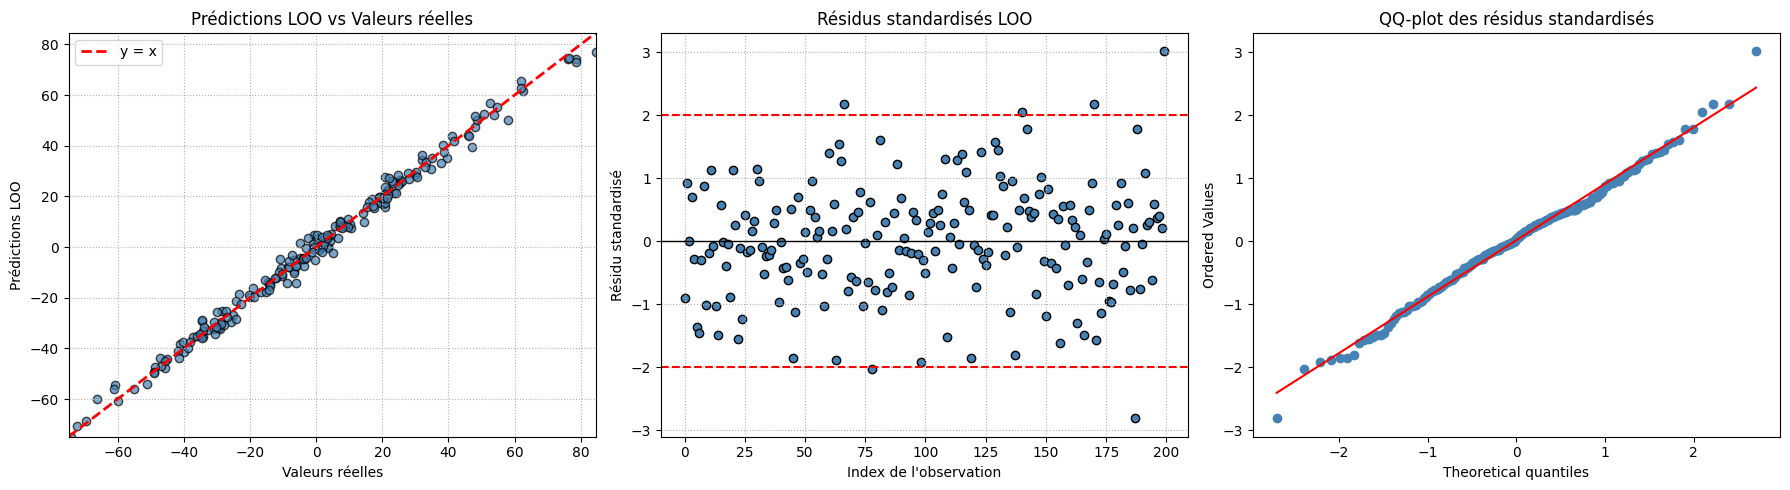

Prédiction effectuée pour la composante principale  1

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [1.8031]              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ floa

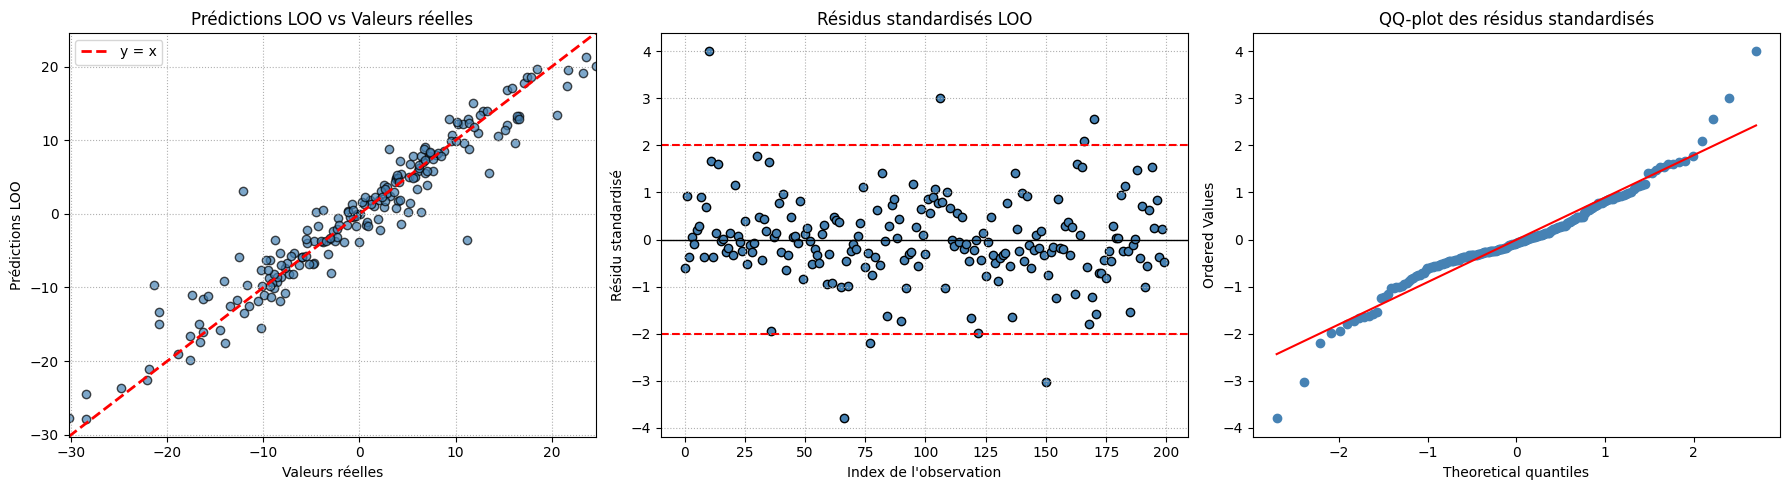

Prédiction effectuée pour la composante principale  2

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [2.49946]              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

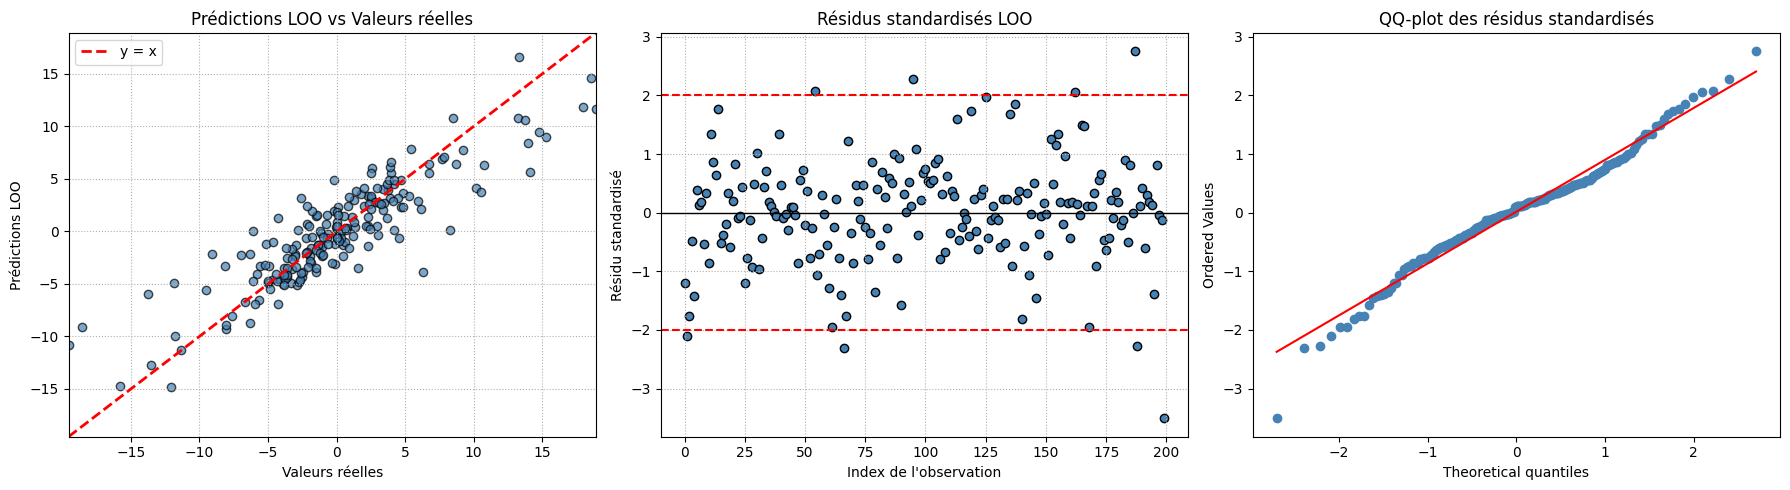

Prédiction effectuée pour la composante principale  3

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.12770333]          │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

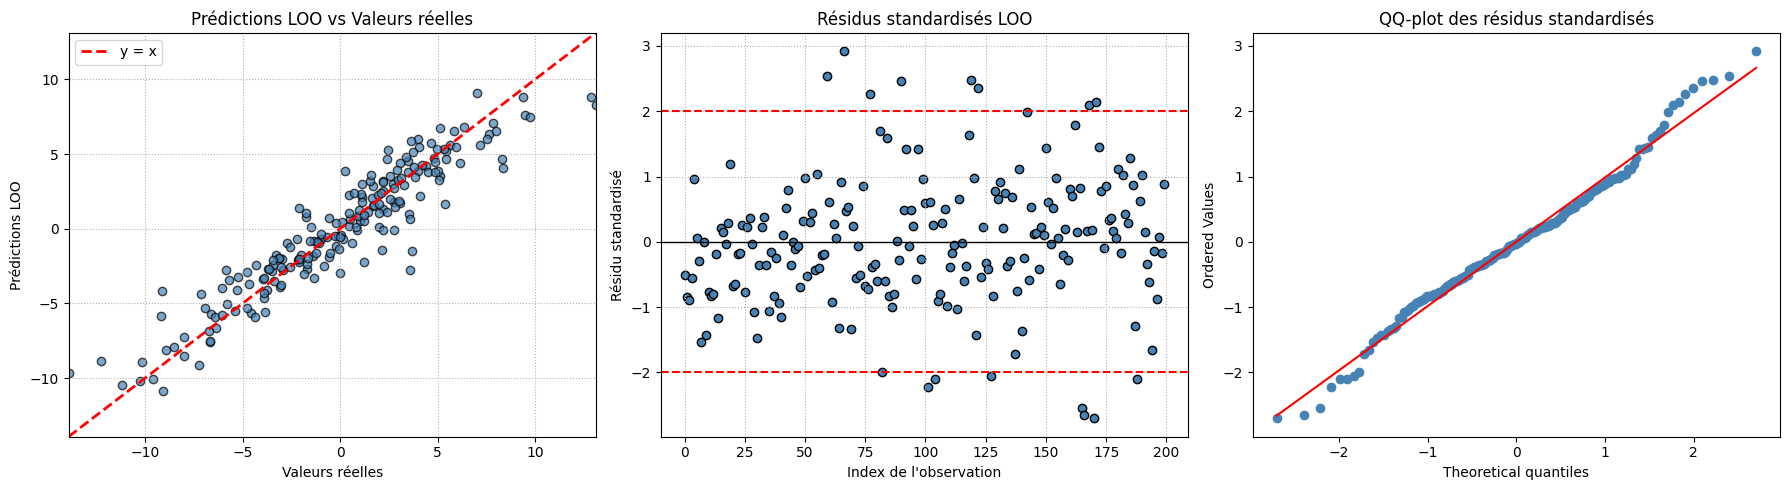

Prédiction effectuée pour la composante principale  4

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.10528053]          │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ floa

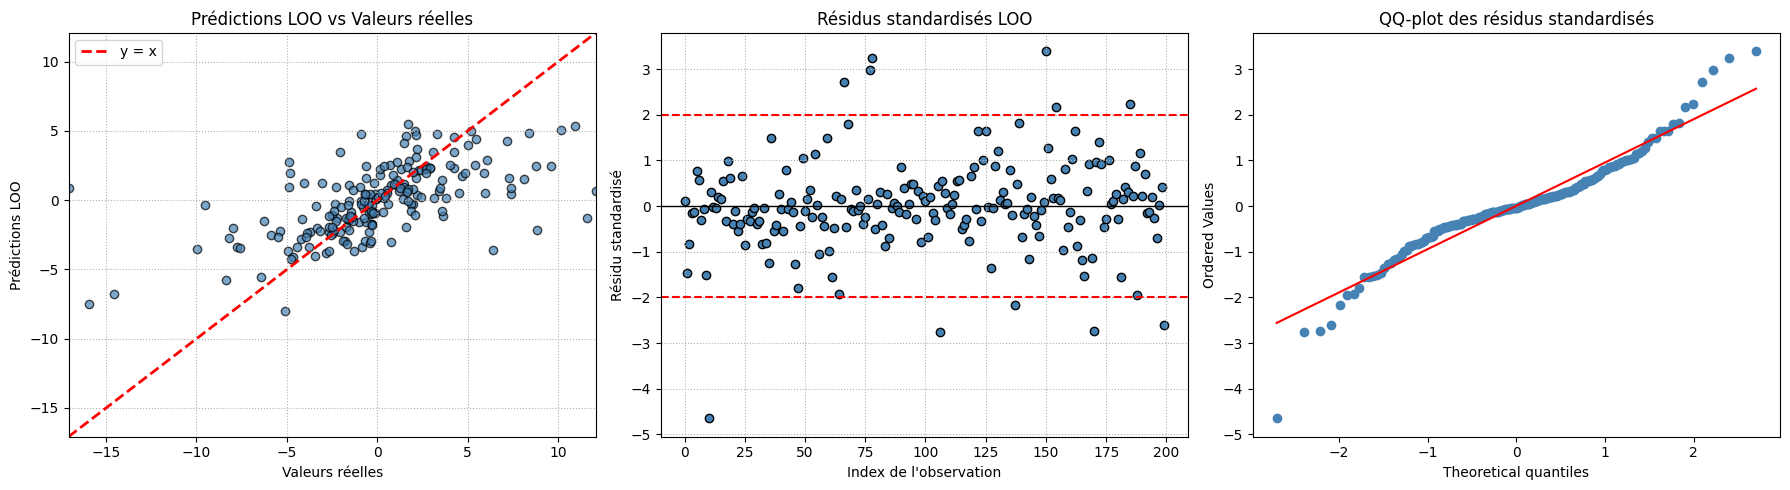

Prédiction effectuée pour la composante principale  5


In [12]:
# APC Classique
Y_test_reconstruct_ACP = ACPF.ACP(x_train,x_test,y_train,t,n_pc,[theta,sigma]) 

Le vecteur de noeuds utilisé pour la décompostion B-spline : [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]
taille du vecteur de y_train: (200, 4096)
taille de la base B-spline : 400
--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.82876903 0.09262352 0.02813522 0.01779917 0.01486437]
Variance globale expliquée : 0.9821913064113332
Taille du jeu d'entrainement transformé par ACP : (200, 5)

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪════

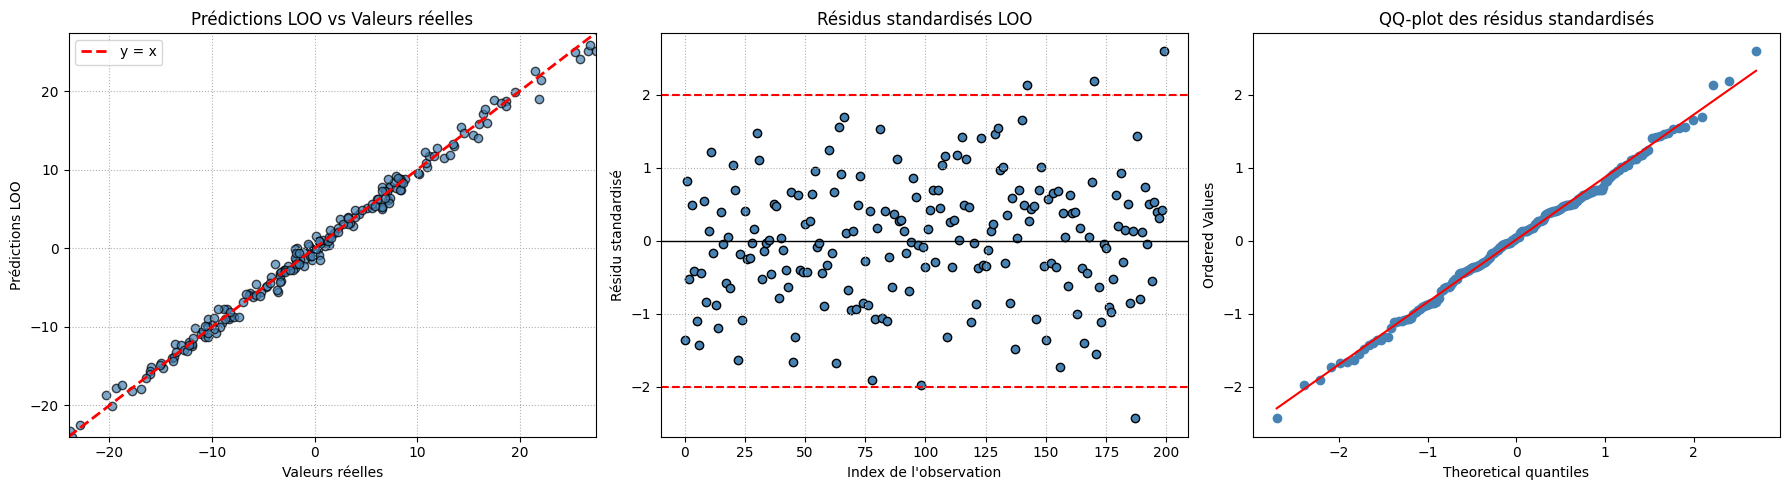

Prédiction effectuée pour la composante principale  1

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.94453006]           │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

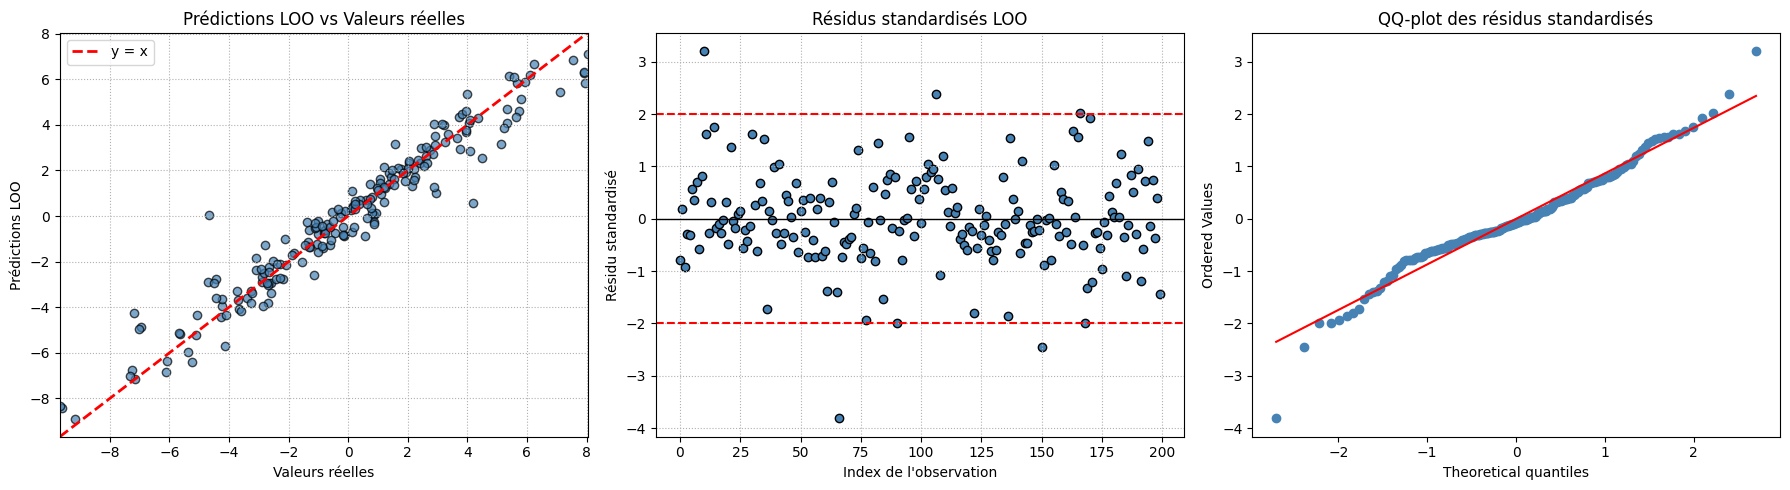

Prédiction effectuée pour la composante principale  2

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.66471133]         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ floa

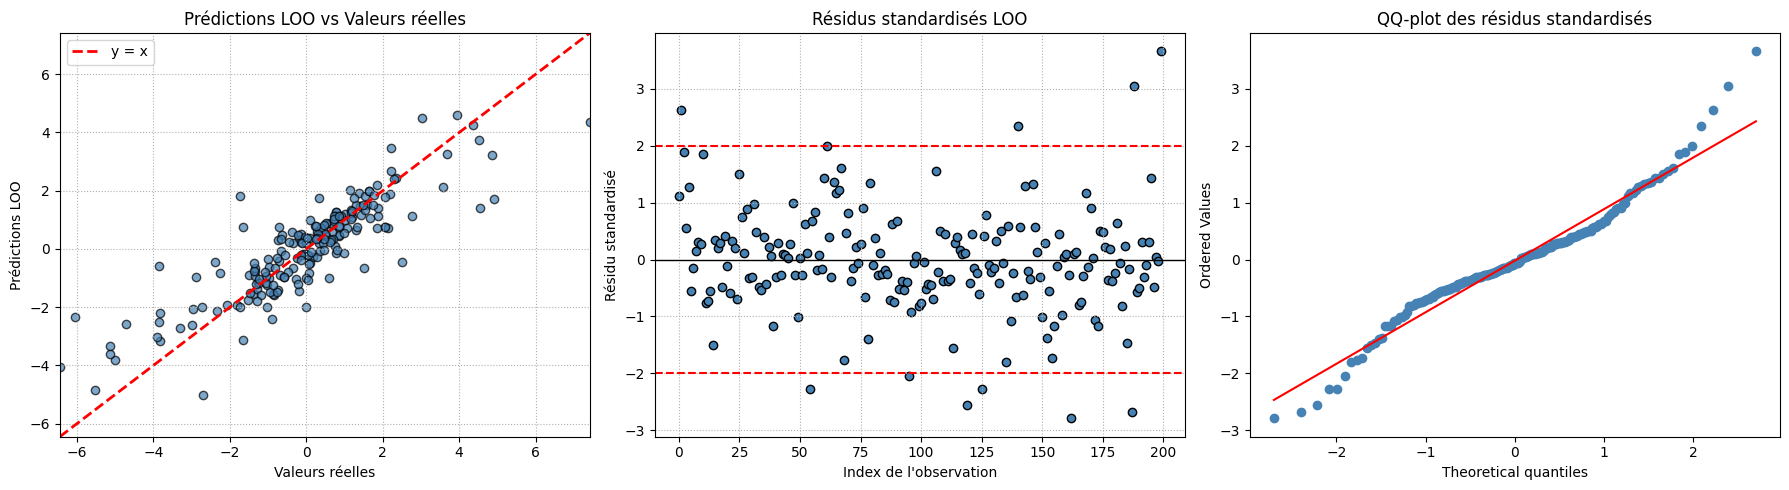

Prédiction effectuée pour la composante principale  3

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.08578838]         │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ floa

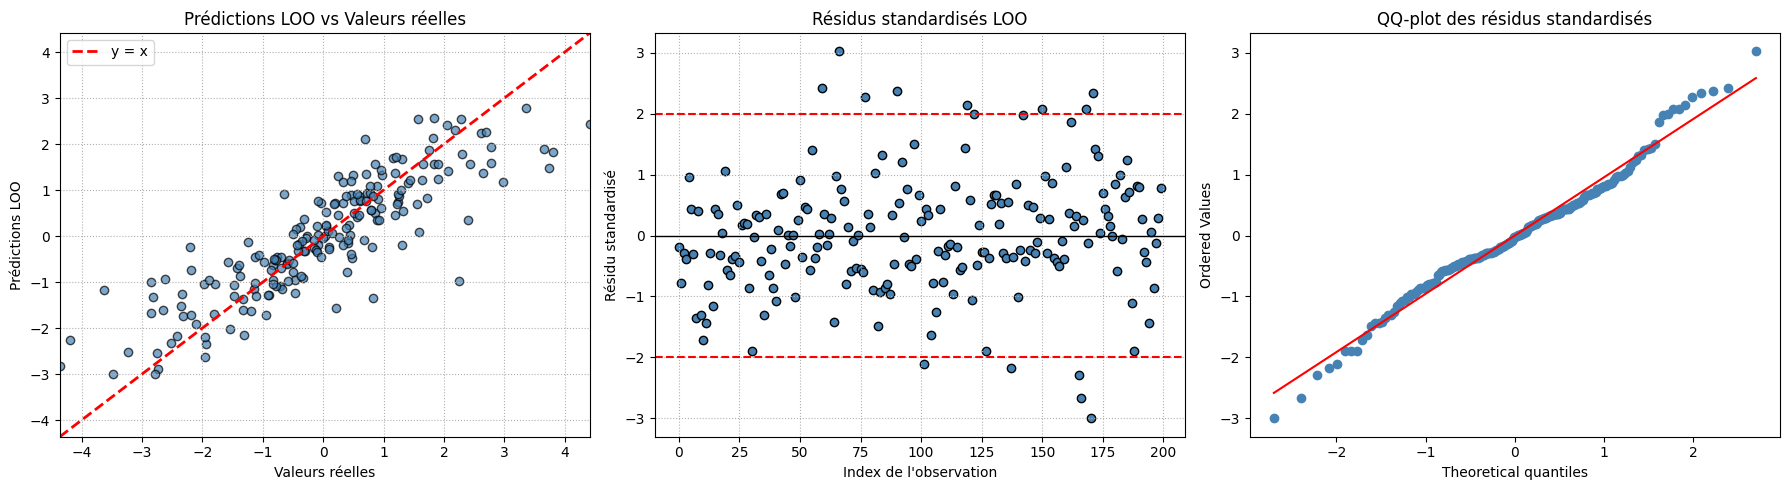

Prédiction effectuée pour la composante principale  4

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.02259276]          │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

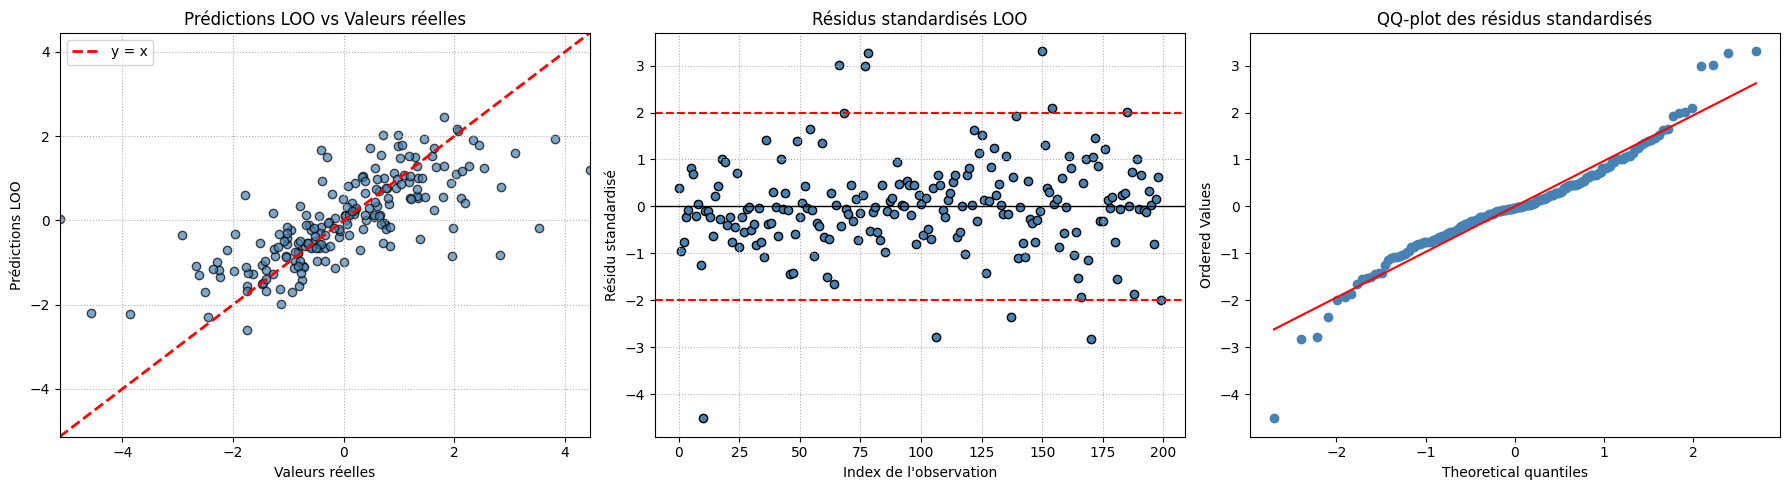

Prédiction effectuée pour la composante principale  5
taille du vecteur de C_reconstruct: (2000, 400)
taille du vecteur de Y_test_reconstruct: (2000, 4096)


In [13]:
# B-spline
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("Le vecteur de noeuds utilisé pour la décompostion B-spline :",t1)
Y_test_reconstruct_Bsplines = ACPF.B_Splines(x_train, x_test, y_train,t1, t1, t, n_pc, [theta,sigma], degree=1)

Nombre de coefficients conservés pour l'ACP : 1353
--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.82619487 0.09399353 0.02937903 0.01823764 0.01501728]
Variance globale expliquée : 0.9828223611273136
Taille du jeu d'entrainement transformé par ACP : (200, 5)

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    

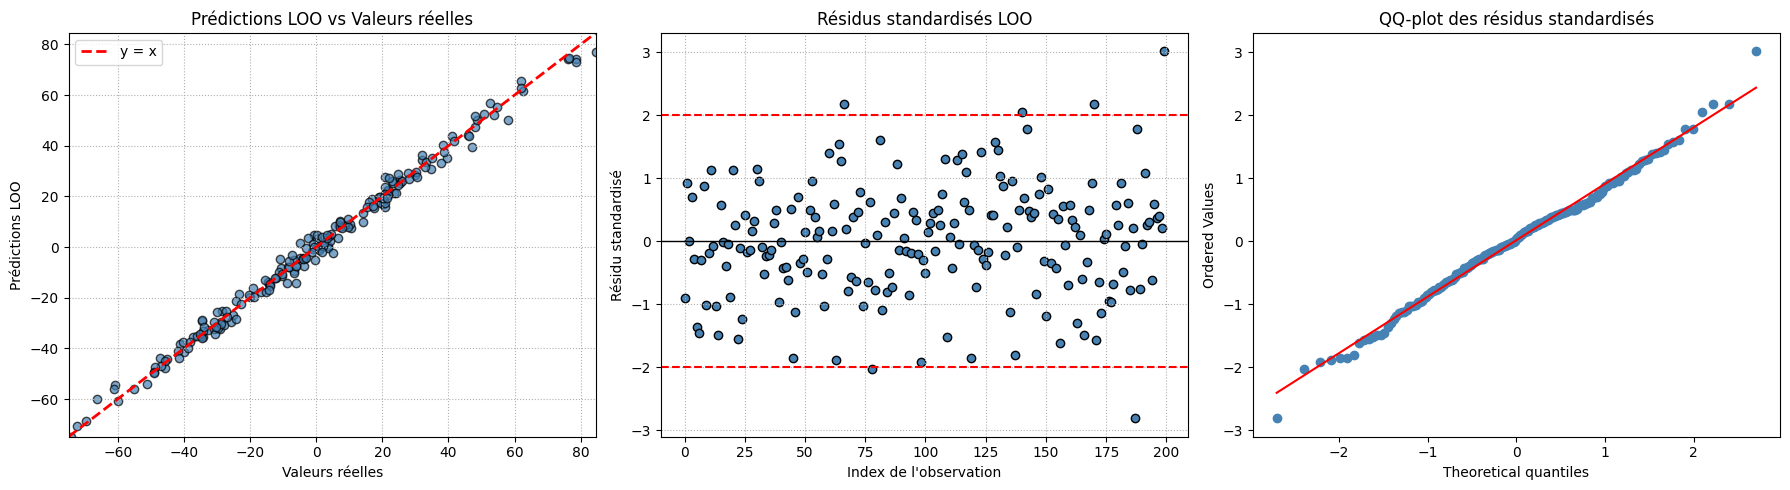

Prédiction effectuée pour la composante principale  1

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [1.80311]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │ floa

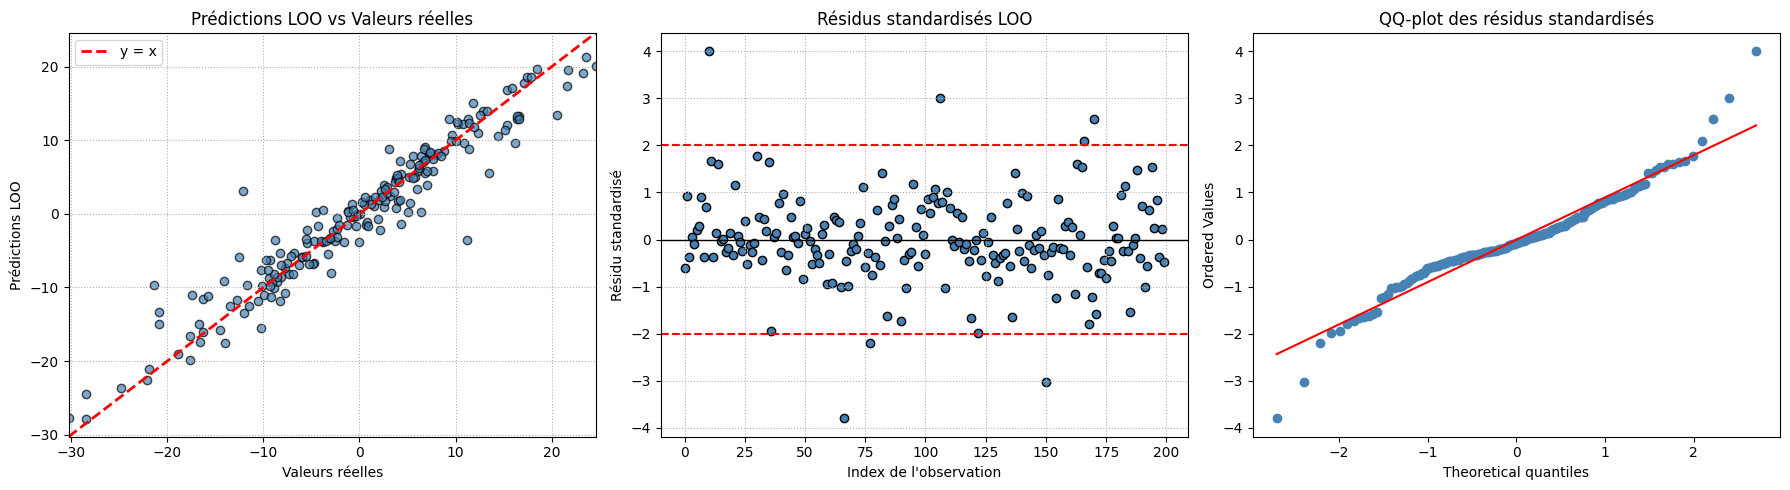

Prédiction effectuée pour la composante principale  2

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [2.49915]              │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

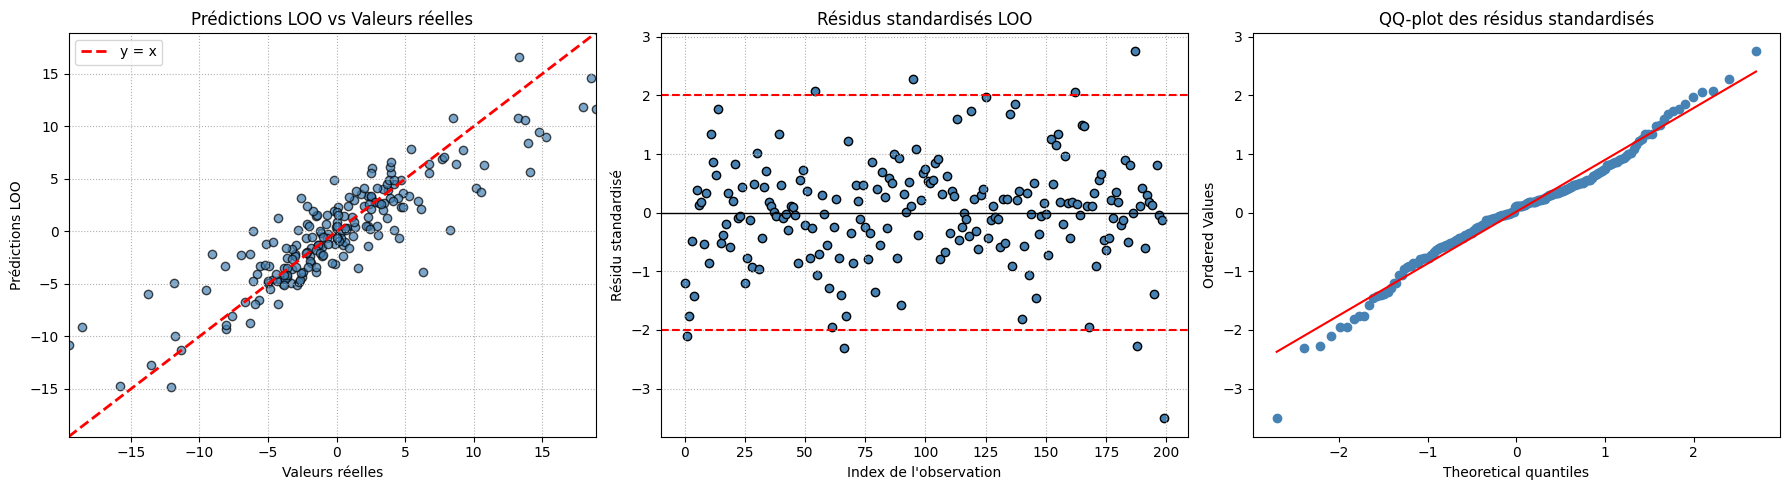

Prédiction effectuée pour la composante principale  3

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [-0.12597169]          │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

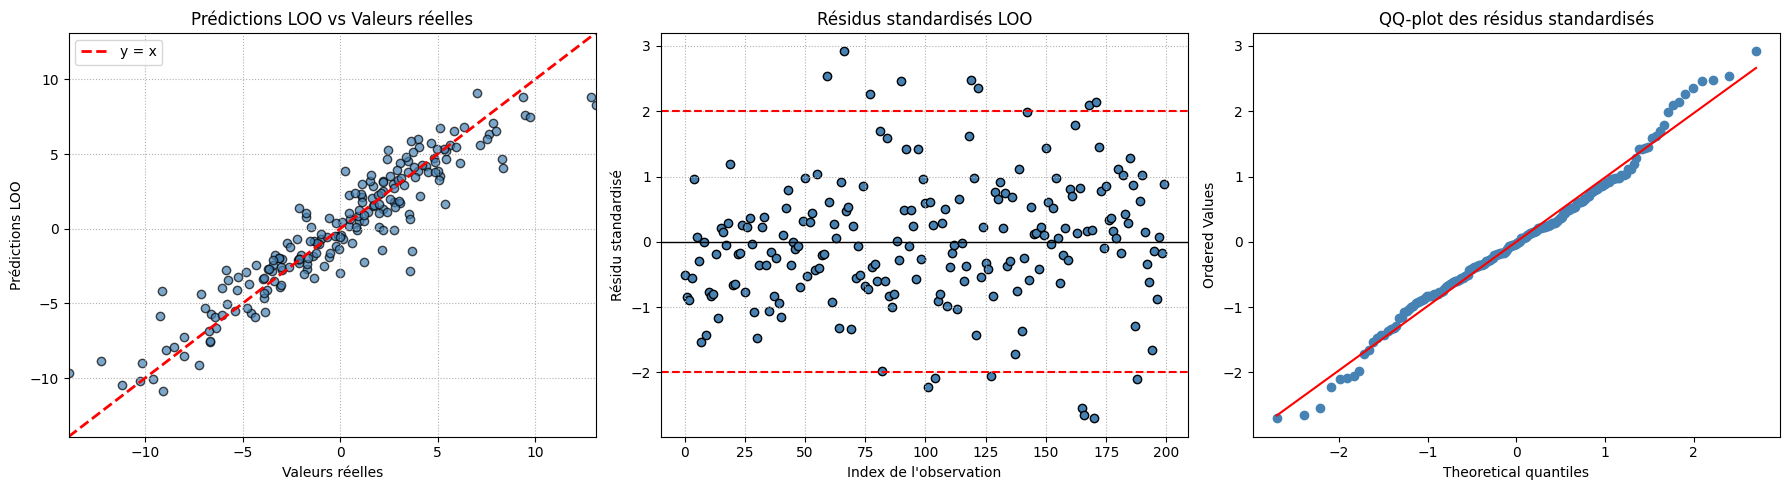

Prédiction effectuée pour la composante principale  4

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [0.10629361]           │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.lengthscale  │ Parameter │ Softplus         │         │ True        │ ()      │

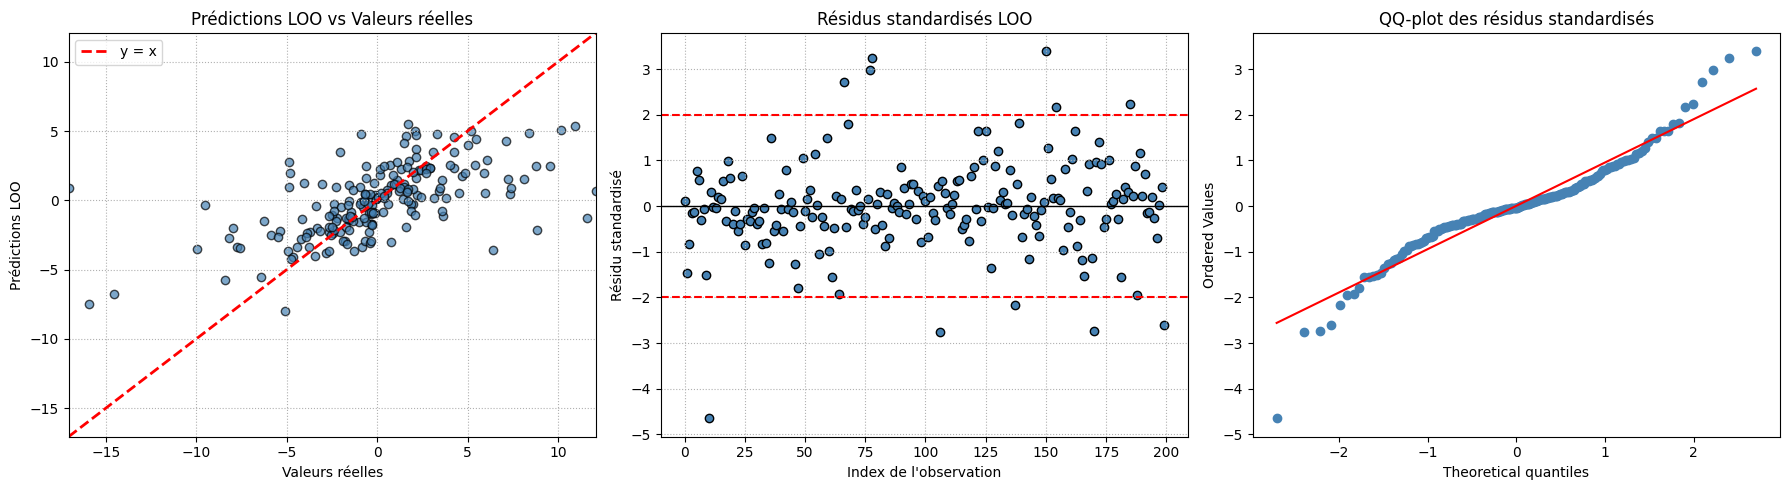

Prédiction effectuée pour la composante principale  5


In [14]:
# Ondelettes 
K_tilde = 1200
p = 0.99999 #Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
Y_test_reconstruct_wavelet = ACPF.Ondelettes(x_train,x_test,y_train,t,n_pc,[theta,sigma],K_tilde=0,p=p,J=2)

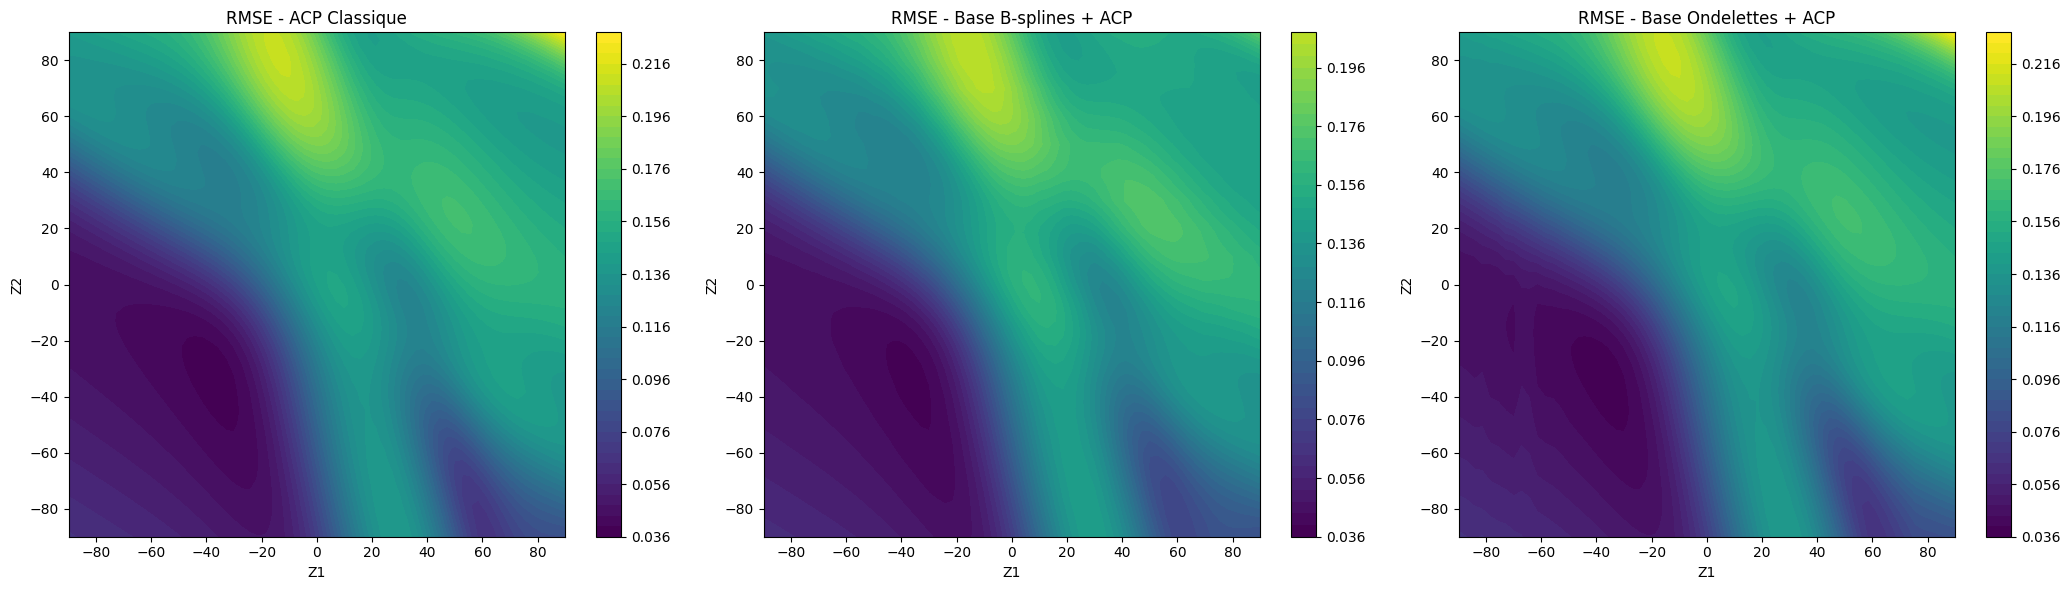

In [15]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
def RMSE_map(test, test_reconstruct):
    return np.sqrt(np.mean((test - test_reconstruct)**2, axis=0)).reshape((n_grid, n_grid))

RMSE_map_ACP = RMSE_map(y_test, Y_test_reconstruct_ACP)
RMSE_map_BS = RMSE_map(y_test, Y_test_reconstruct_Bsplines)
RMSE_map_wavelet = RMSE_map(y_test, Y_test_reconstruct_wavelet)

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()